# Alternative Age Model Stackplot

This Jupyter Notebook explores the process of plotting the stackplot of a set of speleothem oxygen isotope records using alternative age modeling methods (Bacon and COPRA). These methods utilize different algorithms and assumptions than BChron, which may lead to different interpretations of the data.

The main objective of this notebook is to plot the stackplot of speleothem oxygen isotope records using these alternative age models. The data used in this notebook consists of a set of speleothem oxygen isotope records from various cave sites. The records have been preprocessed and are stored in the preprocessed_series_dict dictionary. Additionally, we have age modeling results from Bacon and COPRA stored in the bacon_ens and copra_ens dictionaries, respectively.

In [1]:
import pickle
import os

import pyleoclim as pyleo
import numpy as np
import matplotlib.pyplot as plt
import pyreadr

import matplotlib.transforms as transforms

from matplotlib.ticker import FormatStrFormatter

In [2]:
# We'll use this function to map the ensemble to the paleo data

def mapAgeEnsembleToPaleoData(ensembleValues, paleoValues, ensembleDepth, paleoDepth,
                             value_name = None,value_unit = None,time_name = None,time_unit = None):
    """ Map the depth for the ensemble age values to the paleo values

    Parameters
    ----------

    ensembleValues : array
        A matrix of possible age models. Realizations
        should be stored in columns
        
    paleoValues : 1D array
        A vector containing the paleo data values. The vector
        should have the same length as depthPaleo
        
    ensembleDepth : 1D array
        A vector of depth. The vector should have the same
        length as the number of rows in the ensembleValues
        
    paleoDepth : 1D array
        A vector corresponding to the depth at which there
        are paleodata information
        
    value_name : str
        Paleo data value name
    
    value_unit : str
        Paleo data value unit
    
    time_name : str
        Time name
    
    time_unit : str
        Time unit

    Returns
    -------

    ensemble : pyleoclim.EnsembleSeries
        A matrix of age ensemble on the PaleoData scale

    """

    #Make sure that numpy arrays were given and try to coerce them into vectors if possible
    ensembleDepth=np.squeeze(np.array(ensembleDepth))
    paleoValues = np.squeeze(np.array(paleoValues))
    paleoDepth = np.squeeze(np.array(paleoDepth))

    #Check that arrays are vectors for np.interp
    if paleoValues.ndim > 1:
        raise ValueError('ensembleValues has more than one dimension, please pass it as a 1D array')
    if ensembleDepth.ndim > 1:
        raise ValueError('ensembleDepth has more than one dimension, please pass it as a 1D array')
    if paleoDepth.ndim > 1:
        raise ValueError('paleoDepth has more than one dimension, please pass it as a 1D array')

    if len(ensembleDepth)!=np.shape(ensembleValues)[0]:
        raise ValueError("Ensemble depth and age need to have the same length")
    if len(paleoValues) != len(paleoDepth):
        raise ValueError("Paleo depth and age need to have the same length")

    #Interpolate
    ensembleValuesToPaleo = np.zeros((len(paleoDepth),np.shape(ensembleValues)[1])) #placeholder
    
    for i in np.arange(0,np.shape(ensembleValues)[1]):
        fp,xp = pyleo.utils.tsbase.dropna(ensembleValues[:,i],ensembleDepth) #drop nans
        ensembleValuesToPaleo[:,i]=np.interp(paleoDepth,xp,fp)
    
    series_list = []
    
    for s in ensembleValuesToPaleo.T:
        series_tmp = pyleo.Series(time=s, value=paleoValues,
                       verbose=False,
                       clean_ts=False,
                       value_name=value_name,
                       value_unit=value_unit,
                       time_name=time_name,
                       time_unit=time_unit)
        series_list.append(series_tmp)
    
    ensemble = pyleo.EnsembleSeries(series_list=series_list) #Only including the holocene

    return ensemble

In [3]:
with open('../data/preprocessed_series_dict.pkl','rb') as handle:
    preprocessed_series_dict = pickle.load(handle)

with open('../data/preprocessed_ens_dict.pkl','rb') as handle:
    preprocessed_ens_dict = pickle.load(handle)

with open('../data/pos_dict.pkl','rb') as handle:
    pos_dict = pickle.load(handle)

with open('../data/palette_dict.pkl','rb') as handle:
    color_palette = pickle.load(handle)

In [4]:
# Sorting for plotting purposes

lat_dict = {series.lat:series.label for series in preprocessed_series_dict.values()}

sort_index = np.sort(np.array(list(lat_dict.keys())))[::-1]
sort_label = [lat_dict[lat] for lat in sort_index]
preprocessed_series_dict = {label:preprocessed_series_dict[label] for label in sort_label} #Sort by latitude
preprocessed_ens_dict = {label:preprocessed_ens_dict[label] for label in sort_label} #Sort by latitude

In [5]:
with open('../data/holo_chrons_study.pkl','rb') as handle:
    holo_chrons = pickle.load(handle)

In [6]:
# Mapping stalagmite names to cave site names.


cave_site_dict = {
    'HS4' : 'Heshang',
#    'SB43' : 'Sanbao',
    'C9961' : 'Jiuxian',
    'LH-2' : 'Lianhua',
    'KMA' : 'Mawmluh',
    'XL26' : 'Xianglong',
    'DA' : 'Dongge',
    'SAH2' : 'Sahiya',
    'Hq-1' : 'Hoq',
#    'D1' : 'Dark',
#    'SN17' : 'Shennong',
    'TA12-2' : 'Tangga',
    'LAVI-4' : 'LaVierge',
    'Q5' : 'Oman'
}

# Bacon

In [7]:
# Specify the directory where the Bacon files are located
bacon_dir = '../data/alt_chrons/SISAL_Bacon/'

# Get the list of files in the Bacon directory
bacon_files = os.listdir(bacon_dir)

# Create an empty dictionary to store the Bacon data
bacon_dict = {}

# Iterate over each file in the Bacon directory
for file in bacon_files:
    # Read the R data file using pyreadr
    res = pyreadr.read_r(f'{bacon_dir}{file}')
    
    # Extract the cave site name from the file name
    name = cave_site_dict[file.split('Bacon')[0][:-1]]
    
    # Get the key of the resulting dictionary from pyreadr
    res_key = list(res.keys())[0]
    
    # Store the Bacon data in the dictionary with the cave site name as the key
    bacon_dict[name] = res[res_key]

In [8]:
#Creating BACON ensembles

bacon_ens = {}

for label in bacon_dict.keys():
    paleo_depth = holo_chrons[label]['depth']
    paleo_values = holo_chrons[label]['d18O']

    # Convert the ensemble depth to mm if the label is not 'Heshang'
    if label not in ['Heshang']:
        ensemble_depth = bacon_dict[label]['depth_sample'] * 10
    else:
        ensemble_depth = bacon_dict[label]['depth_sample']

    # Get the value columns and ensemble values for the current label
    value_columns = list(bacon_dict[label].columns)[2:]
    ensemble_values = bacon_dict[label][value_columns].values

    # Map the age ensemble to the paleo data
    ens = mapAgeEnsembleToPaleoData(ensembleValues=ensemble_values,
                                    paleoValues=paleo_values,
                                    ensembleDepth=ensemble_depth,
                                    paleoDepth=paleo_depth)

    # Preprocess the ensemble series
    preprocessed_ens_list = []
    for series in ens.series_list:
        # Slice the series from 0 to 10000 and interpolate
        preprocessed_series = series.slice((0, 10000)).interp().detrend(method='savitzky-golay')
        preprocessed_ens_list.append(preprocessed_series)
    preprocessed_ens = pyleo.EnsembleSeries(preprocessed_ens_list)

    # Store the preprocessed ensemble series in the bacon_ens dictionary
    bacon_ens[label] = preprocessed_ens

bacon_ens = {label:bacon_ens[label] for label in sort_label if label in bacon_ens.keys()} #Sort by latitude

/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/pyleoclim/utils/tsutils.py:1400: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating...")
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/pyleoclim/utils/tsutils.py:1400: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating...")
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/pyleoclim/utils/tsutils.py:1400: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating...")
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/pyleoclim/utils/tsutils.py:1400: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating...")
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site

/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


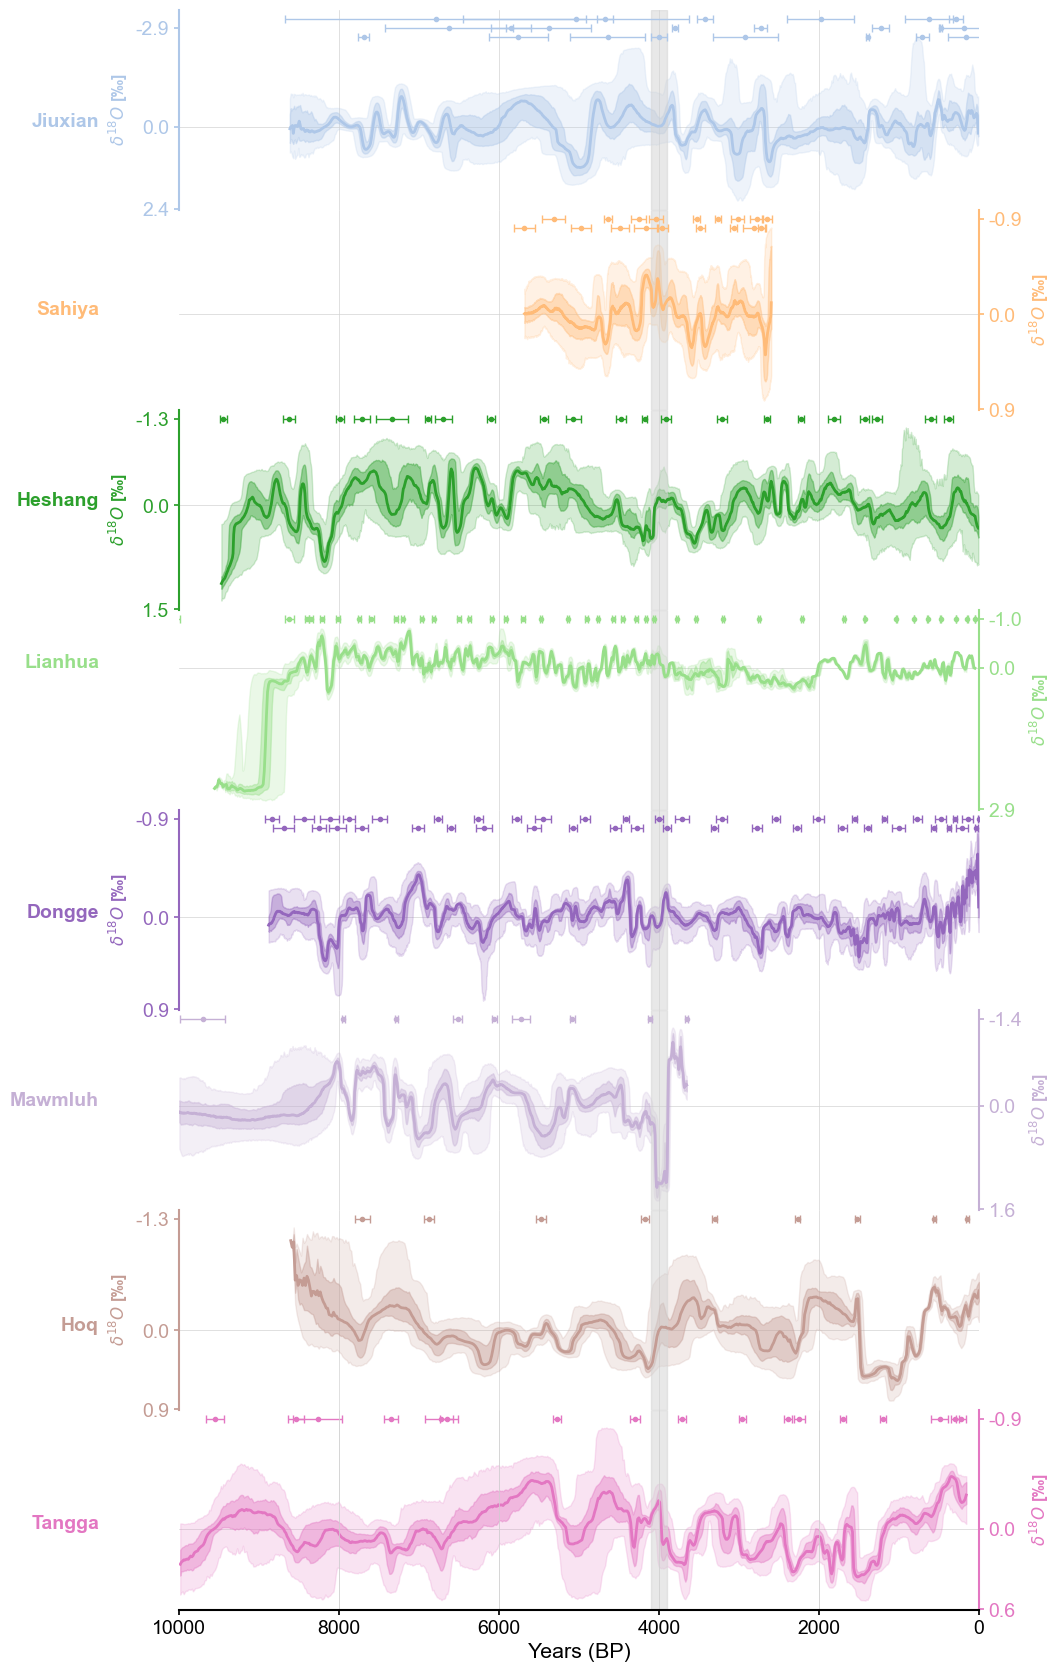

In [9]:
# Setting up the figure with a specific size
fig = plt.figure(figsize=(8, 16))

# Defining various parameters for the plot
xlim = [0, 10000]
n_ts = len(bacon_ens)
fill_between_alpha = 0.2
cmap = 'tab20'
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

# Creating a dictionary to store the axes for each subplot
ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

# Iterating over each item in bacon_ens to create subplots
for idx, pair in enumerate(bacon_ens.items()):
    label, ens = pair
    color = color_palette[label]
    bottom -= height * v_shift_factor
    ax[idx] = fig.add_axes([left, bottom, width, height])

    # Plotting the envelope for each ensemble
    ens.common_time(time_axis=preprocessed_series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)
    
    # Configuring the appearance of each subplot
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)

    # Adding label to each subplot
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.1, 0, label, horizontalalignment='right', transform=trans, color=color, weight='bold')
    
    # Configuring y-axis ticks and formatting
    ylim = ax[idx].get_ylim()
    ax[idx].set_yticks([ylim[0], 0, ylim[-1]])
    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)

    # Configuring spines and y-axis appearance based on even/odd index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()

    # Calculating offset for error bars
    ylim_mag = max(ylim) - min(ylim)
    offset = ylim_mag * .05

    # Plotting error bars based on the label
    if label in ['Xianglong', 'Dongge', 'Sahiya', 'Liuli']:
        ax[idx].errorbar(holo_chrons[label]['dating_age'][0::2], [ylim[0]] * len(holo_chrons[label]['dating_age'][0::2]), xerr=holo_chrons[label]['dating_error'][0::2], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][1::2], [ylim[0] + offset] * len(holo_chrons[label]['dating_age'][1::2]), xerr=holo_chrons[label]['dating_error'][1::2], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    elif label in ['Jiuxian', 'Jiulong']:
        ax[idx].errorbar(holo_chrons[label]['dating_age'][0::3], [ylim[0]] * len(holo_chrons[label]['dating_age'][0::3]), xerr=holo_chrons[label]['dating_error'][0::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][1::3], [ylim[0] + offset] * len(holo_chrons[label]['dating_age'][1::3]), xerr=holo_chrons[label]['dating_error'][1::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][2::3], [ylim[0] - offset] * len(holo_chrons[label]['dating_age'][2::3]), xerr=holo_chrons[label]['dating_error'][2::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    else:
        ax[idx].errorbar(holo_chrons[label]['dating_age'], [ylim[0]] * len(holo_chrons[label]['dating_age']), xerr=holo_chrons[label]['dating_error'], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)

    # Configuring y-axis label and tick colors
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)

    # Configuring spines and x-axis appearance
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])

    # Adding vertical grid lines
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)

    # Adding horizontal line at y=0
    ax[idx].axhline(y=0, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)

    # Inverting x-axis and y-axis
    ax[idx].invert_xaxis()
    ax[idx].invert_yaxis()

    # Adding a vertical span to highlight a specific range
    ax[idx].axvspan(4100, 3900, color='lightgrey', alpha=0.5)

# Creating the bottom subplot for the time axis
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])

# Configuring the bottom subplot
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)

# Adding vertical grid lines to the bottom subplot
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)

# Inverting x-axis and y-axis of the bottom subplot
ax[n_ts].invert_xaxis()
ax[n_ts].invert_yaxis()

# COPRA

In [10]:
#Loading the chron data from sisal files

copra_dir = '../../data/alt_chrons/SISAL_COPRA/'
copra_files = os.listdir(copra_dir)
copra_dict = {}

for file in copra_files:
    res = pyreadr.read_r(f'{copra_dir}{file}')
    name = cave_site_dict[file.split('copRa')[0][:-1]]
    res_key = list(res.keys())[0]
    copra_dict[name] = res[res_key]

In [11]:
#Creating COPRA ensembles

copra_ens = {}

for label in copra_dict.keys():
    paleo_depth = holo_chrons[label]['depth']
    paleo_values = holo_chrons[label]['d18O']

    #Convert the ensemble depth to mm if the label is 'Heshang'
    if label  in ['Heshang']:
        ensemble_depth = copra_dict[label]['depth_sample'] / 10
    else:
        ensemble_depth = copra_dict[label]['depth_sample']

    # Get the value columns and ensemble values for the current label
    value_columns = list(copra_dict[label].columns)[2:]
    ensemble_values = copra_dict[label][value_columns].values

    # Map the age ensemble to the paleo data
    ens = mapAgeEnsembleToPaleoData(ensembleValues=ensemble_values,
                                    paleoValues=paleo_values,
                                    ensembleDepth=ensemble_depth,
                                    paleoDepth=paleo_depth)

    # Preprocess the ensemble series
    preprocessed_ens_list = []
    for series in ens.series_list:
        # Slice the series from 0 to 10000 and interpolate
        preprocessed_series = series.slice((0, 10000)).interp().detrend(method='savitzky-golay')
        preprocessed_ens_list.append(preprocessed_series)
    preprocessed_ens = pyleo.EnsembleSeries(preprocessed_ens_list)

    # Store the preprocessed ensemble series in the copra_ens dictionary
    copra_ens[label] = preprocessed_ens

copra_ens = {label:copra_ens[label] for label in sort_label if label in copra_ens.keys()} #Sort by latitude

/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/pyleoclim/utils/tsutils.py:1400: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating...")
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/pyleoclim/utils/tsutils.py:1400: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating...")
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/pyleoclim/utils/tsutils.py:1400: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating...")
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/pyleoclim/utils/tsutils.py:1400: UserWarning: Timeseries is not evenly-spaced, interpolating...
  warnings.warn("Timeseries is not evenly-spaced, interpolating...")
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site

/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/Users/alexjames/miniconda3/envs/asc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


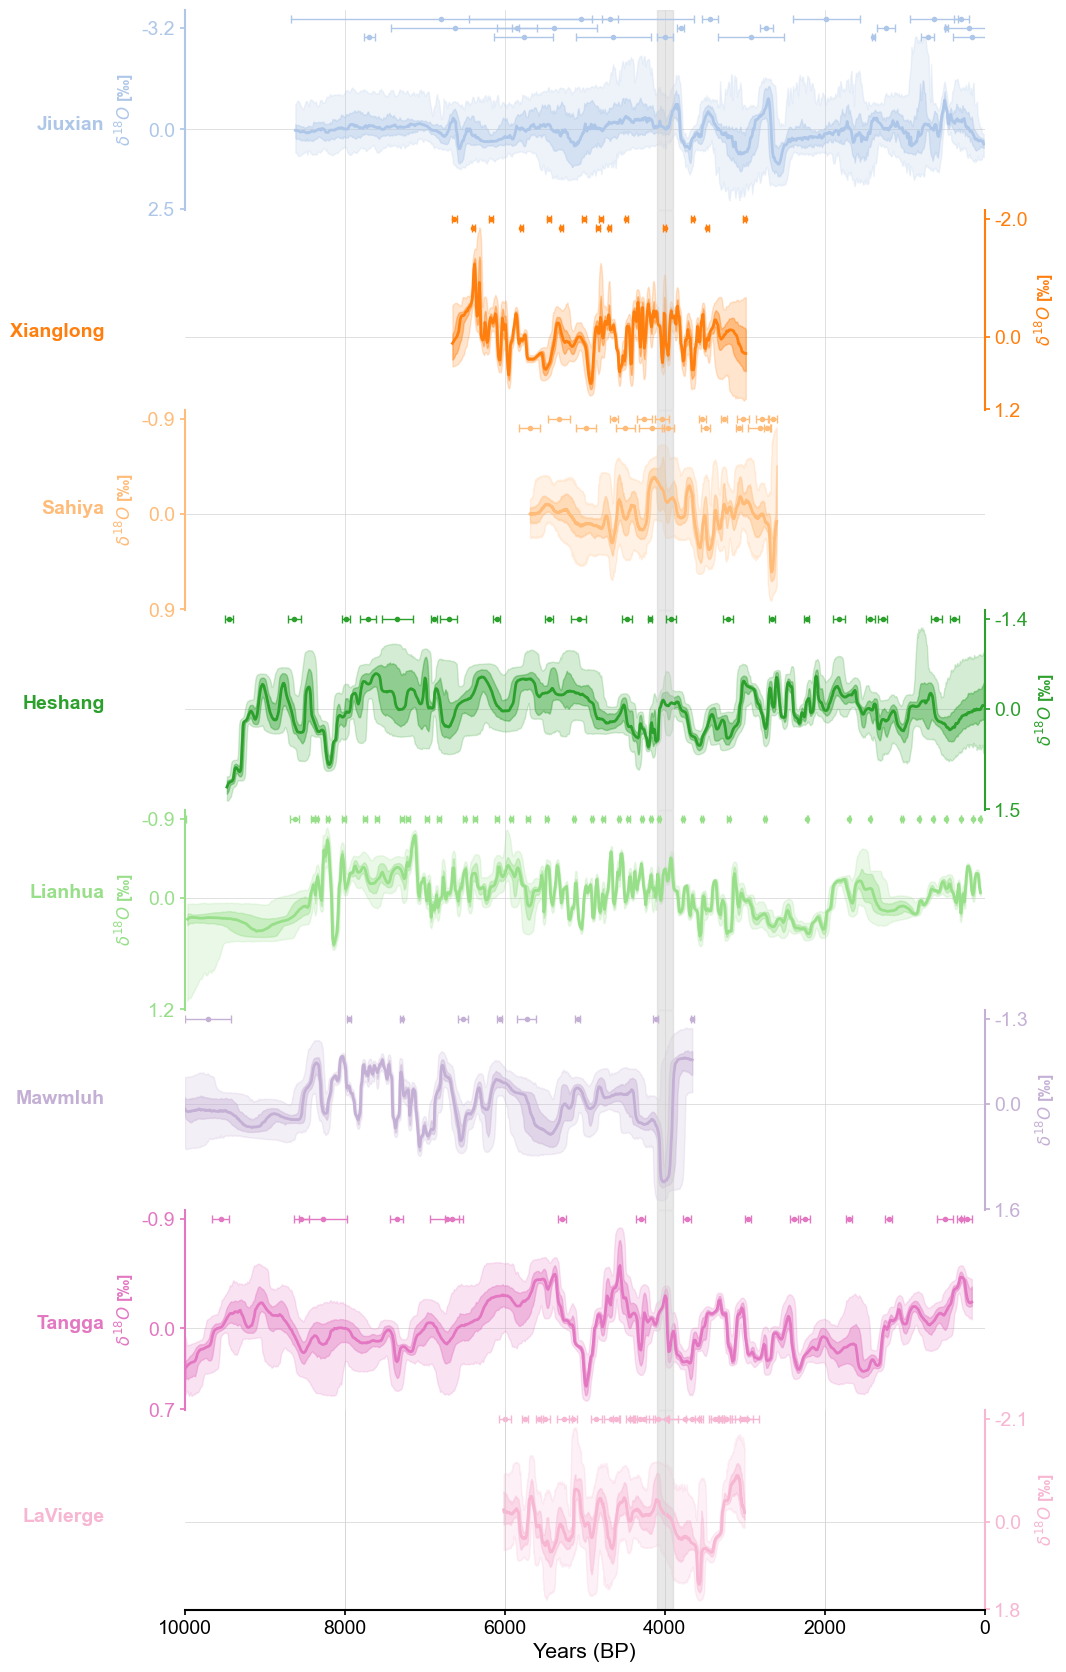

In [12]:
# Setting up the figure with a specific size
fig = plt.figure(figsize=(8, 16))

# Defining various parameters for the plot
xlim = [0, 10000]
n_ts = len(bacon_ens)
fill_between_alpha = 0.2
cmap = 'tab20'
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

# Creating a dictionary to store the axes for each subplot
ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

# Iterating over each item in bacon_ens to create subplots
for idx, pair in enumerate(copra_ens.items()):
    label, ens = pair
    color = color_palette[label]
    bottom -= height * v_shift_factor
    ax[idx] = fig.add_axes([left, bottom, width, height])

    # Plotting the envelope for each ensemble
    ens.common_time(time_axis=preprocessed_series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)
    
    # Configuring the appearance of each subplot
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)

    # Adding label to each subplot
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.1, 0, label, horizontalalignment='right', transform=trans, color=color, weight='bold')
    
    # Configuring y-axis ticks and formatting
    ylim = ax[idx].get_ylim()
    ax[idx].set_yticks([ylim[0], 0, ylim[-1]])
    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)

    # Configuring spines and y-axis appearance based on even/odd index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()

    # Calculating offset for error bars
    ylim_mag = max(ylim) - min(ylim)
    offset = ylim_mag * .05

    # Plotting error bars based on the label
    if label in ['Xianglong', 'Dongge', 'Sahiya', 'Liuli']:
        ax[idx].errorbar(holo_chrons[label]['dating_age'][0::2], [ylim[0]] * len(holo_chrons[label]['dating_age'][0::2]), xerr=holo_chrons[label]['dating_error'][0::2], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][1::2], [ylim[0] + offset] * len(holo_chrons[label]['dating_age'][1::2]), xerr=holo_chrons[label]['dating_error'][1::2], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    elif label in ['Jiuxian', 'Jiulong']:
        ax[idx].errorbar(holo_chrons[label]['dating_age'][0::3], [ylim[0]] * len(holo_chrons[label]['dating_age'][0::3]), xerr=holo_chrons[label]['dating_error'][0::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][1::3], [ylim[0] + offset] * len(holo_chrons[label]['dating_age'][1::3]), xerr=holo_chrons[label]['dating_error'][1::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
        ax[idx].errorbar(holo_chrons[label]['dating_age'][2::3], [ylim[0] - offset] * len(holo_chrons[label]['dating_age'][2::3]), xerr=holo_chrons[label]['dating_error'][2::3], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)
    else:
        ax[idx].errorbar(holo_chrons[label]['dating_age'], [ylim[0]] * len(holo_chrons[label]['dating_age']), xerr=holo_chrons[label]['dating_error'], color=color, fmt='o', ms=3, capsize=3, elinewidth=1)

    # Configuring y-axis label and tick colors
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)

    # Configuring spines and x-axis appearance
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])

    # Adding vertical grid lines
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)

    # Adding horizontal line at y=0
    ax[idx].axhline(y=0, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)

    # Inverting x-axis and y-axis
    ax[idx].invert_xaxis()
    ax[idx].invert_yaxis()

    # Adding a vertical span to highlight a specific range
    ax[idx].axvspan(4100, 3900, color='lightgrey', alpha=0.5)

# Creating the bottom subplot for the time axis
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])

# Configuring the bottom subplot
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)

# Adding vertical grid lines to the bottom subplot
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)

# Inverting x-axis and y-axis of the bottom subplot
ax[n_ts].invert_xaxis()
ax[n_ts].invert_yaxis()